# Investigate burst firing


## Imports

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

import pickle


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [5]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)


## Load Original Data (Only Run Once)

In [ ]:
with open('data_bio482.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Add AP Information (Only Run Once)

Using the Function_Detect_APs function, we can extract the details of the APs per sweep. For each entry in the original dataframe, we append the information about the APs in the Sweep_MembranePotential.

In [ ]:
def explain_ap(ap_params):
    return {
        'ap_thresh_vm': ap_params[1],
        'ap_peak_times': ap_params[2],
        'ap_peak_vm': ap_params[3],
        'ap_peak_amp': ap_params[4],
        'ap_duration': ap_params[5]
    }

In [ ]:
def process_sweep(row):
    """Process a single row to detect and explain action potentials."""
    sr_vm = row['Sweep_MembranePotential_SamplingRate']
    ap_vm_deriv_thresh = row['Cell_APThreshold_Slope']
    potential_across_time = row['Sweep_MembranePotential']

    # Detect action potentials
    ap_params = Function_Detect_APs(potential_across_time, sr_vm, ap_vm_deriv_thresh)

    # Return a dictionary of explained APs
    return {ap[0]: explain_ap(ap) for ap in ap_params}



In [ ]:
# Apply the function to each row
ap_info = data_df.apply(process_sweep, axis=1)


In [ ]:
ap_info

In [ ]:
data_df['ap_info'] = ap_info

In [ ]:
path = "/content/drive/MyDrive/NSCCM/"
file_to_save = "data_with_AP_info"
data_df.to_pickle(f'{path}{file_to_save}.pkl')

## Import New Pickle

No need to run last 2 sections if you already have data_with_AP_info.pkl file in your directory. It is too large to push to github.

In [6]:
with open('data_with_AP_info.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Visualise Data:

In [5]:
data_df.head()

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe..."
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe..."


Each entry in the dataframe represents some sweep. There may be multiple sweeps per cell (as represented by Sweep_Counter) and so multiple entries with the same Cell_ID. Each entry has a Membrane Potential vs Time measure which can be visualised below:

In [15]:
def plot_aps(data_df, sweep_num, save_figure=False):

    sweep = data_df.iloc[sweep_num]

    sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
    membrane_potential = sweep['Sweep_MembranePotential']
    
    time = [i/sr_vm for i in range(len(membrane_potential))]
    
    ap_peak_times = np.array([ap["ap_peak_times"] for ap in sweep["ap_info"].values()])
    ap_peak_vm = np.array([ap["ap_peak_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_vm = np.array([ap["ap_thresh_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_times = np.array([key for key in sweep["ap_info"].keys()])

    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)
    
    ax.set_title(f'APs for Sweep {sweep_num}')
    ax.plot(time, membrane_potential, lw=0.5,  zorder=0)
    ax.scatter(ap_peak_times, ap_peak_vm, lw=0.5, marker='+', color='r')
    ax.scatter(ap_thresh_times, ap_thresh_vm, lw=0.1, marker='o', color='b')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Vm (V)')
    plt.xlim(2.5,10)
    
    if save_figure:
        # Save figure
        fname = os.path.join('images', f'Example_Cell_{sweep_num}.png')
        plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


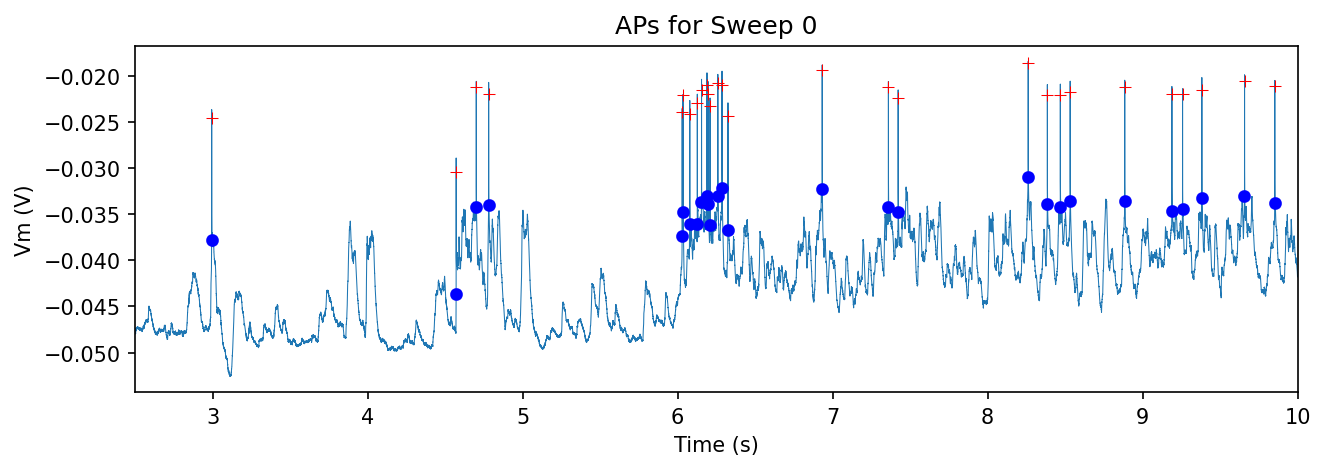

In [16]:
plot_aps(data_df, 0, save_figure = True)